# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
# Импорт библиотек
import pandas as pd 
import numpy as np
import warnings

from sklearn.model_selection import cross_val_score
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
warnings.filterwarnings('ignore')

### Получение и анализ данных

In [2]:
df = pd.read_csv('/datasets/autos.csv')

In [3]:
display(df.info())
display(df.head())
display(df.tail())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26
354368,2016-03-20 19:41:08,3400,wagon,2002,manual,100,golf,150000,6,gasoline,volkswagen,NaN,2016-03-20 00:00:00,0,40764,2016-03-24 12:45:21


In [4]:
display(df.describe())
display(df.describe(include=['object']))
display('Полных дубликатов:', df.duplicated().sum())

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


,DateCrawled,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired,DateCreated,LastSeen
count,354369,316879,334536,334664,321474,354369,283215,354369,354369
unique,271174,8,2,250,7,40,2,109,179150
top,2016-03-24 14:49:47,sedan,manual,golf,petrol,volkswagen,no,2016-04-03 00:00:00,2016-04-06 13:45:54
freq,7,91457,268251,29232,216352,77013,247161,13719,17


'Полных дубликатов:'

4

<b> Предварительный анализ</b> полученных данных позволил выявить следующие особенности:
1) датасет содержит 354365 строк и 16 столбцов;<br>
2) столбец Price(цена (евро)) содержит нулевые значения, которые могут повлиять на обучение модели;<br>
3) в столбцах RegistrationYear (год регистрации автомобиля) и RegistrationMonth (месяц регистрации автомобиля) присутствуют недостоверные данные: год не может быть 1000 или 9999, месяц не может быть 0;<br>
4) в столбце Power(мощность л.с.) присутствуют аномальные значения (менее 10 и более 500 л.с., что не может соответствовать действительности исходя из природы изучаемых данных);<br>
5) в столбце Kilometer(пробег (км)) значения ограничены 150000, что наводит на мысль о каких либо ограничениях или фильтрах при формировании датасета;<br>
6) присутствуют пропуски в столбцах VehicleType(тип автомобильного кузова - 37490 шт.), Gearbox(тип коробки передач - 19833шт.), Model(модель автомобиля - 19705шт.), FuelType(тип топлива - 32895шт.) и NotRepaired(была машина в ремонте или нет - 71154шт.);<br>
7) в стобце NumberOfPictures(количество фотографий автомобиля) отсутствуют данные;<br>
8) вывлено 4 полных дубликата данных.

### Предобработка

<b> Для оптимизации вычислительного времени и приведения данных к реальным значениям проведем предобработку

In [5]:
# Уделание полных дубликатов
df.drop_duplicates(inplace = True)

#### Удаление несущественных для поставленной задачи столбцов

In [6]:
#Оставим значимые столбцы для дальнейшей обработки
df = df[['Price', 'VehicleType', 
         'RegistrationYear', 'RegistrationMonth',
         'Gearbox', 'Power', 'Model',
         'Kilometer', 'FuelType',
         'Brand', 'NotRepaired']]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              354365 non-null  int64 
 1   VehicleType        316875 non-null  object
 2   RegistrationYear   354365 non-null  int64 
 3   RegistrationMonth  354365 non-null  int64 
 4   Gearbox            334532 non-null  object
 5   Power              354365 non-null  int64 
 6   Model              334660 non-null  object
 7   Kilometer          354365 non-null  int64 
 8   FuelType           321470 non-null  object
 9   Brand              354365 non-null  object
 10  NotRepaired        283211 non-null  object
dtypes: int64(5), object(6)
memory usage: 32.4+ MB


Что привело к экономии в использовании памяти более 30%

#### Обработка пропущенных и нулевых значений

In [7]:
df.isna().sum().sort_values(ascending=False) / df.shape[0] * 100

NotRepaired          20.079297
VehicleType          10.579487
FuelType              9.282802
Gearbox               5.596772
Model                 5.560651
Price                 0.000000
RegistrationYear      0.000000
RegistrationMonth     0.000000
Power                 0.000000
Kilometer             0.000000
Brand                 0.000000
dtype: float64

<b> Объем пропущенных значений по столбцам:</b>

 - 20% в столбце NotRepaired(вероятно владельцы пропустили это значения из-за отсутствия или намеренного сокрытия информации);
 - 10% в столбце VehicleType(подстановка значений не представляется возможной);
 - 9% в столбце FuelType(подстановка значений не представляется возможной);
 - 5% в столбце GearBox(подстановка значений не представляется возможной, пустые значения лучше удалить);
 - 5% в столбце Model(можем предположить, что наименование модели отсутствовало в справочнике, т.к. редкие автомобили могут значительно отличаться в цене, пустые значения лучше удалить).

##### Cтолбец Price (цена в евро)

<AxesSubplot:>

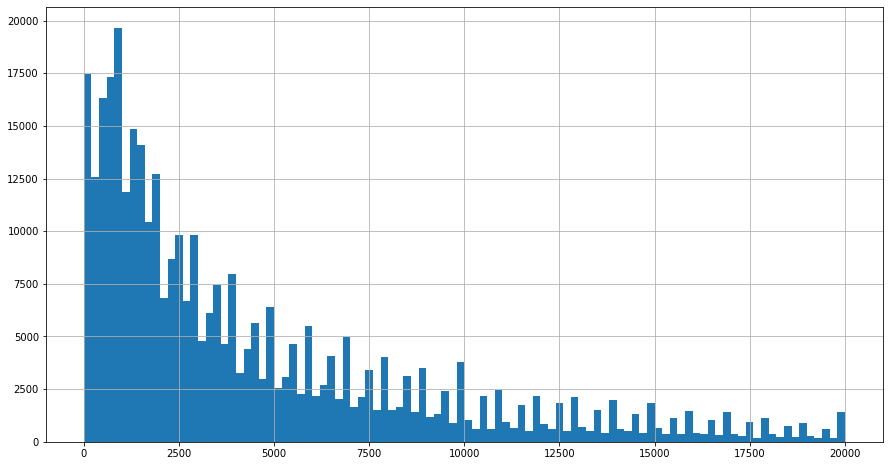

In [8]:
# Проверим наполнение целевого признака
df['Price'].hist(bins=100, figsize=(15,8))

<b> Удалим значения дешевле 50 евро, т.к. такая стоимость автомобиля даже на запчасти не имеет смысла (природа таких значений возможна из-за ошибки в заполнении или пропущенных значений)

In [9]:
df = df.query('Price > 50')

##### Столбцы RegistrationYear (год регистрации автомобиля) и RegistrationMonth (месяц регистрации автомобиля)

Удалим недостоверные данные

<AxesSubplot:>

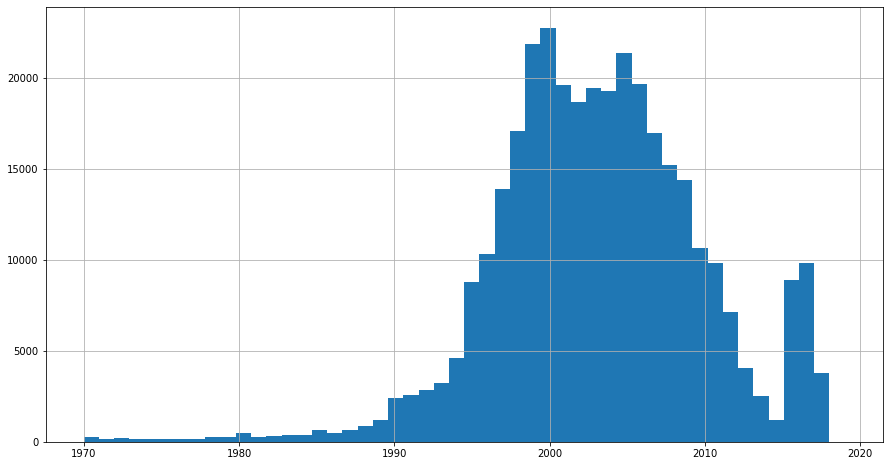

In [10]:
# Проверим наполнение признака с учетом поправки на суть значения
# Значения до 1970 года удалим, т.к. их стоимость формируется на основании антикварной ценности экземпляров
# Значения после 2020 года невозможны
df = df.query('1969 < RegistrationYear < 2020')
df['RegistrationYear'].hist(bins=50, figsize=(15,8))

<AxesSubplot:>

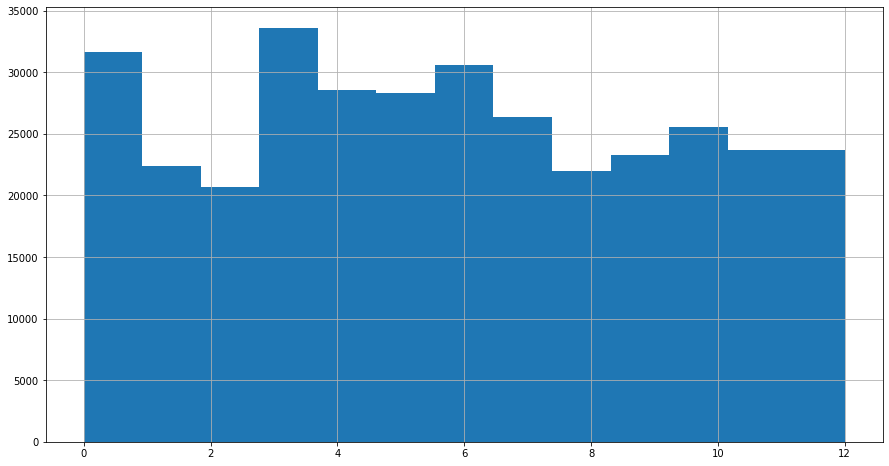

In [11]:
# Проверим наполнение признака
df['RegistrationMonth'].hist(bins=13, figsize=(15,8))

Исходя из распределения, можно предположить, что строки со значением месяца **0** заполнялись по принципу **не указано**, т.к. имеют не значительное количество (на общем фоне) и выброс на фоне соседних месяцев.

Для очистки от "**шума**" при обучении, значение **0** удалим

In [12]:
df = df.query('RegistrationMonth > 0')

##### Столбец Power (мощность л.с.)

Удалим из столбца Power аномальные значения (менее 10 и более 500 л.с., т.к. за пределами данного диапазона для автомобилей природа занчений данных вызывает большие сомнения из-за малой распространенности серийного производства таких машин)

<AxesSubplot:>

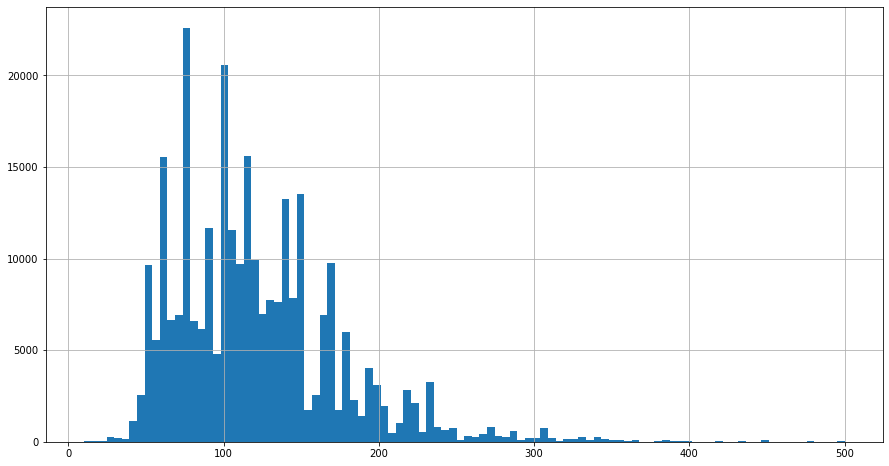

In [13]:
df = df.query('9 < Power < 501')
df['Power'].hist(bins=100, figsize=(15,8))

##### Столбец Kilometer(пробег, км)

в столбце Kilometer(пробег (км)) значения ограничены 150000, что наводит на мысль о каких либо ограничениях или фильтрах при формировании датасета

<AxesSubplot:>

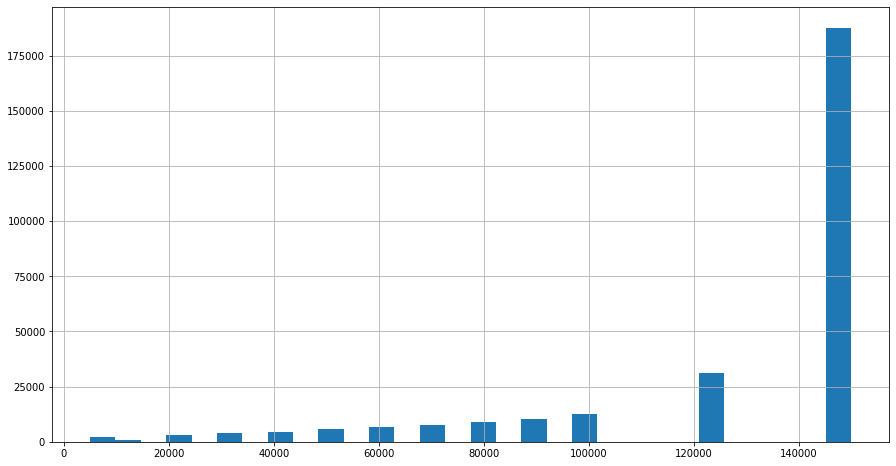

In [14]:
df['Kilometer'].hist(bins=30, figsize=(15,8))

Судя по распределению, значение пробега несёт условный характер

##### Столбец NotRepaired (была машина в ремонте или нет)

Заменим отсутствующие значения предположением, что машина не была в ремонте.

In [15]:
df['NotRepaired'] = df['NotRepaired'].fillna('no')

##### Столбцы VehicleType (тип автомобильного кузова), VehicleType (тип автомобильного кузова), GearBox (тип коробки передач) и Model (модель автомобиля) 

Заполнение пропусков в данных столбцах может привести в совокумности к значительным искажениям при формировании модели и считаю необходимым их удалить

In [16]:
df = df.dropna().reset_index(drop=True)
print(df.isnull().sum())

Price                0
VehicleType          0
RegistrationYear     0
RegistrationMonth    0
Gearbox              0
Power                0
Model                0
Kilometer            0
FuelType             0
Brand                0
NotRepaired          0
dtype: int64


In [17]:
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252646 entries, 0 to 252645
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              252646 non-null  int64 
 1   VehicleType        252646 non-null  object
 2   RegistrationYear   252646 non-null  int64 
 3   RegistrationMonth  252646 non-null  int64 
 4   Gearbox            252646 non-null  object
 5   Power              252646 non-null  int64 
 6   Model              252646 non-null  object
 7   Kilometer          252646 non-null  int64 
 8   FuelType           252646 non-null  object
 9   Brand              252646 non-null  object
 10  NotRepaired        252646 non-null  object
dtypes: int64(5), object(6)
memory usage: 21.2+ MB


<b> Вывод по данным</b>

1) Была изучена таблица данных.<br>
2) Удалены аномальные и пропущенные значения.<br>
3) Выделены небходимые столбцы для обучения модели.<br>
4) Заполнены пропуски в столбцах и удалены некорректные значения.
5) Достигрута значительная экономия ресурсов памяти (долее 50%), что ускорит обучение модели.

**После предобработки** мы удалили 35% данных, НО можем утверждать о результирующем высоком качестве полученной выборки пригодной для дельнейшего моделирования


## Обучение моделей

Выберем следующие регрессоры для обучения:
<b>
 - Градиентный бустинг (LGBMRegressor);
 - Линейная регрессия (LinearRegression);
 - Решающее дерево (DecisionTreeRegressor).</b>

В качестве метрики для для оценки всех моделей будем использовать RMSE. Качество моделей будем проверять на кроссвалидации.

Подготовим 3 типа признаков для кроссвалидации:
 - Оригинальные (org_features);
 - Закодированные Прямым кодированием OE (ord_features);
 - Закодированные Фиктивным кодированием OHE (ohe_features).

In [18]:
#Оригинальные принаки
org_features = df.drop('Price', axis=1)

#Прямое кодирование
encd = OrdinalEncoder()
cat_columns = ['VehicleType','Gearbox','Model','FuelType','Brand','NotRepaired']
cat_features = org_features[cat_columns]
cat_features = pd.DataFrame(encd.fit_transform(cat_features),
                                columns=cat_features.columns, 
                                index=cat_features.index)
ord_features = org_features.copy()
for column in cat_columns:
    ord_features[column] = cat_features[column]

# Фиктивное кодирование
ohe_features = pd.get_dummies(org_features, drop_first=True)

#Целевой признак
targ = df['Price']

In [19]:
org_features_tr, org_features_t, targ_tr, targ_t = train_test_split(
    org_features, targ, test_size=0.25, random_state=12345)

ord_features_tr = ord_features.loc[org_features_tr.index, :]
ord_features_t = ord_features.loc[org_features_t.index, :]

ohe_features_tr = ohe_features.loc[org_features_tr.index, :]
ohe_features_t = ohe_features.loc[org_features_t.index, :]

### Градиентный бустинг (LGBMRegressor)

%%time
print("Обучение Градиентным бустингом c Прямым кодированием (OE)")
hyperparams = [{'num_leaves':[20, 60, 100], 
                'learning_rate':[0.1, 0.3, 0.5],
                'random_state':[12345]}]
lgbm = GridSearchCV(LGBMRegressor(), hyperparams, scoring='neg_mean_squared_error')
lgbm.fit(ord_features_tr, targ_tr)
print("Наилучшие найденные параметры:")
print(lgbm.best_params_)
print("Поле параметров:")
means = lgbm.cv_results_['mean_test_score']
stds = lgbm.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, lgbm.cv_results_['params']):
    print("%0.3f for %r"% ((mean*-1)** 0.5, params))
RMSE_LGBM = (max(means)*-1) ** 0.5
print("RMSE для Градиентного бустинга c Прямым кодированием (OE) =", RMSE_LGBM)

In [20]:
%%time
model = LGBMRegressor(learning_rate=0.3, 
                      num_leaves=100, 
                      random_state=12345)
model.fit(ord_features_tr, targ_tr)

targ_pred = model.predict(ord_features_t)

f_RMSE_LGBMR = mean_squared_error(targ_t, targ_pred) ** 0.5
print("RMSE для Градиентного бустинга c Прямым кодированием (OE) на тестовой выборке =", f_RMSE_LGBMR)

RMSE для Градиентного бустинга c Прямым кодированием (OE) на тестовой выборке = 1533.628225605426
CPU times: user 10min 17s, sys: 6.2 s, total: 10min 23s
Wall time: 10min 28s


### Линейная регрессия (LinearRegression)

#### Проведем обучение без масштабирования

In [21]:
%%time
print("Обучение Линейной регрессией без масштабирования")
RMSE_LR = (cross_val_score(LinearRegression(), ohe_features_tr, targ_tr, 
                             cv=5, scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print("RMSE для Линейной регрессии без масштабирования =", RMSE_LR)

Обучение Линейной регрессией без масштабирования
RMSE для Линейной регрессии без масштабирования = 2436.0770731606276
CPU times: user 1min 15s, sys: 2min 32s, total: 3min 47s
Wall time: 3min 48s


In [22]:
%%time
model = LinearRegression()
model.fit(ohe_features_tr, targ_tr)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

targ_pred = model.predict(ohe_features_t)

f_RMSE_LR = mean_squared_error(targ_t, targ_pred) ** 0.5
print("RMSE для Линейной регрессии без масштабирования на тестовой выборке =", f_RMSE_LR)

RMSE для Линейной регрессии без масштабирования на тестовой выборке = 2448.098109137804
CPU times: user 18.6 s, sys: 38.4 s, total: 57 s
Wall time: 57.3 s


#### Проведем обучение с масштабированием

In [23]:
%%time
print("Обучение Линейной регрессией с масштабированием")
RMSE_LRs = (cross_val_score(Pipeline([("standard_scaller", StandardScaler()),
                            ("linear_regression", LinearRegression())]),
                            ohe_features_tr, targ_tr, 
                            cv=5, scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print("RMSE для Линейной регрессии после масштабирования =", RMSE_LRs)

Обучение Линейной регрессией с масштабированием
RMSE для Линейной регрессии после масштабирования = 7729303991268.882
CPU times: user 1min 15s, sys: 2min 24s, total: 3min 39s
Wall time: 3min 40s


**Масштабирование значительно ухудшило показатели модели.
Дальнейшее рассмотрения данной модели с масштабированием безсмысленно.**

### Решающее дерево (DecisionTreeRegressor)

#### Проведем обучение на признаках закодированных через Прямое кодирование (ОЕ)

In [24]:
%%time
print("Обучение Решающим деревом c Прямым кодированием (OE)")
max_depth_list = [x for x in range(2, 41)]
hyperparams = [{'criterion':['mse'], 
                'max_depth':max_depth_list, 
                'random_state':[12345]}]
dtr = GridSearchCV(DecisionTreeRegressor(), hyperparams, scoring='neg_mean_squared_error')
dtr.fit(ord_features_tr, targ_tr)
print("Наилучшие найденные параметры:")
print(dtr.best_params_)
print("Поле параметров:")
means = dtr.cv_results_['mean_test_score']
stds = dtr.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, dtr.cv_results_['params']):
    print("%0.3f for %r"% ((mean*-1)** 0.5, params))
RMSE_DTR_OE = (max(means)*-1) ** 0.5
print("RMSE для Решающего дерева c Прямым кодированием (OE) =", RMSE_DTR_OE)

Обучение Решающим деревом c Прямым кодированием (OE)
Наилучшие найденные параметры:
{'criterion': 'mse', 'max_depth': 14, 'random_state': 12345}
Поле параметров:
3121.906 for {'criterion': 'mse', 'max_depth': 2, 'random_state': 12345}
2755.173 for {'criterion': 'mse', 'max_depth': 3, 'random_state': 12345}
2509.906 for {'criterion': 'mse', 'max_depth': 4, 'random_state': 12345}
2336.918 for {'criterion': 'mse', 'max_depth': 5, 'random_state': 12345}
2226.379 for {'criterion': 'mse', 'max_depth': 6, 'random_state': 12345}
2135.476 for {'criterion': 'mse', 'max_depth': 7, 'random_state': 12345}
2058.192 for {'criterion': 'mse', 'max_depth': 8, 'random_state': 12345}
1995.421 for {'criterion': 'mse', 'max_depth': 9, 'random_state': 12345}
1940.044 for {'criterion': 'mse', 'max_depth': 10, 'random_state': 12345}
1895.792 for {'criterion': 'mse', 'max_depth': 11, 'random_state': 12345}
1862.441 for {'criterion': 'mse', 'max_depth': 12, 'random_state': 12345}
1844.682 for {'criterion': 'mse'

In [25]:
%%time
model = DecisionTreeRegressor(criterion='mse', 
                              max_depth=14, 
                              random_state=12345) 
model.fit(ord_features_tr, targ_tr)
targ_pred = model.predict(ord_features_t)
f_RMSE_DTR_OE = mean_squared_error(targ_t, targ_pred) ** 0.5
print("RMSE для Решающего дерева c Прямым кодированием (OE) на тестовой выборке =", f_RMSE_DTR_OE)

RMSE для Решающего дерева c Прямым кодированием (OE) на тестовой выборке = 1834.7691200753254
CPU times: user 596 ms, sys: 4.36 ms, total: 600 ms
Wall time: 602 ms


#### Проведем обучение на признаках закодированных через Фиктивное кодирование (OHE)

In [26]:
%%time
print("Обучение Решающим деревом c Фиктивным кодированием (OHE)")
max_depth_list = [x for x in range(2, 41)]
hyperparams = [{'criterion':['mse'], 
                'max_depth':max_depth_list, 
                'random_state':[12345]}]
dtr = GridSearchCV(DecisionTreeRegressor(), hyperparams, scoring='neg_mean_squared_error')
dtr.fit(ohe_features_tr, targ_tr)
print("Наилучшие найденные параметры:")
print(dtr.best_params_)
print("Поле параметров:")
means = dtr.cv_results_['mean_test_score']
stds = dtr.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, dtr.cv_results_['params']):
    print("%0.3f for %r"% ((mean*-1)** 0.5, params))
RMSE_DTR_OHE = (max(means)*-1) ** 0.5
print("RMSE для Решающего дерева c Фиктивным кодированием (OHE) =", RMSE_DTR_OHE)

Обучение Решающим деревом c Фиктивным кодированием (OHE)
Наилучшие найденные параметры:
{'criterion': 'mse', 'max_depth': 17, 'random_state': 12345}
Поле параметров:
3121.906 for {'criterion': 'mse', 'max_depth': 2, 'random_state': 12345}
2755.173 for {'criterion': 'mse', 'max_depth': 3, 'random_state': 12345}
2508.139 for {'criterion': 'mse', 'max_depth': 4, 'random_state': 12345}
2339.017 for {'criterion': 'mse', 'max_depth': 5, 'random_state': 12345}
2217.653 for {'criterion': 'mse', 'max_depth': 6, 'random_state': 12345}
2132.903 for {'criterion': 'mse', 'max_depth': 7, 'random_state': 12345}
2055.747 for {'criterion': 'mse', 'max_depth': 8, 'random_state': 12345}
1995.080 for {'criterion': 'mse', 'max_depth': 9, 'random_state': 12345}
1946.408 for {'criterion': 'mse', 'max_depth': 10, 'random_state': 12345}
1909.835 for {'criterion': 'mse', 'max_depth': 11, 'random_state': 12345}
1871.998 for {'criterion': 'mse', 'max_depth': 12, 'random_state': 12345}
1849.137 for {'criterion': '

In [27]:
%%time
model = DecisionTreeRegressor(criterion='mse', 
                              max_depth=17, 
                              random_state=12345) 
model.fit(ohe_features_tr, targ_tr)
targ_pred = model.predict(ohe_features_t)
f_RMSE_DTR_OHE = mean_squared_error(targ_t, targ_pred) ** 0.5
print("RMSE для Решающего дерева c Фиктивным кодированием (OHE) на тестовой выборке =", f_RMSE_DTR_OHE)

RMSE для Решающего дерева c Фиктивным кодированием (OHE) на тестовой выборке = 1818.4135230326872
CPU times: user 4.97 s, sys: 268 ms, total: 5.23 s
Wall time: 5.27 s


**На данном этапе изучены результаты по 3-м моделям**

## Анализ моделей

### Сравнение моделей

In [28]:
res = {
    'Model' : ['LGBMRegressor', 'DecisionTreeRegressor(OE)','DecisionTreeRegressor(OHE)', 'LinearRegression'],
    'Train RMSE' :pd.Series([1525.92, 1837.99, 1828.11, 2436.08]),
    'Train Time, sec': pd.Series([559, 90, 697, 63]),
    'Test RMSE' :pd.Series([1533.63, 1834.77, 1818.41, 2448.10]),
    'Test Time, sec': pd.Series([6.18, 0.517, 4.59, 15.9])
    }
display(pd.DataFrame(res))

,Model,Train RMSE,"Train Time, sec",Test RMSE,"Test Time, sec"
0,LGBMRegressor,1525.92,559,1533.63,6.180
1,DecisionTreeRegressor(OE),1837.99,90,1834.77,0.517
2,DecisionTreeRegressor(OHE),1828.11,697,1818.41,4.590
3,LinearRegression,2436.08,63,2448.10,15.900


### Итоговые выводы

1) На начальном этапе были получены данные и проведена их предобработка, результатом которой стала рафинация достоверных показателей и оптимизация их размера.<br>

2) Проведено изучение моделей Линейной регрессии (LinearRegression), Решающего дерева (DecisionTreeRegressor) и Градиентного бустинга (LGBMRegressor) с различным набором гиперпараметров.<br>

3) Лидером по **КАЧЕСТВУ** безусловно стал **Градиентный бусстинг** с показателем **RMSE около 1530**. НО время его работы может оказаться неприемлемой роскощью для оперативного анализа.<br>

4) Среди лидеров по **СКОРОСТИ РАБОТЫ** можно выделить **Линейную регрессию и Решающее дерево** (с гиперпараметрами, полученными через прямое кодирование). Скорость их обработки в десятки раз превосходит остальные рассматриваемые модели. <br>

5) Если предположить, что рассматриваемые показатели равноценны по весу **в рейтинге, ЛИДЕРОМ** по совокупным показателям стоит выделить **Решающее дерево с прямым кодированием признаков**, как приемлемое по качеству предсказания, но значительно выигрывающее по скорости работы.<br>